<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5,scale=(0.02,0.33),ratio=(0.3,3.3),value=0,inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [17]:
num_epochs = 50
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    torch.save(net.state_dict(), f'Weight_Epoch{epoch+1}.pth')
    scheduler.step()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: Loss: 2.1408, Train Accuracy: 25.75%
Test Accuracy: 37.46%
Confusion Matrix (Epoch 1):
[[664  68  24   2   9   6  25  34 150  18]
 [ 91 679   4   1   1   2  34  14 127  47]
 [182  44 154   3 228  69 102 190  17  11]
 [113  75  82  23  46 245 191 194   8  23]
 [117  27 100   4 295  47 141 253   8   8]
 [ 62  64  85  19  44 340  89 278  12   7]
 [ 33  44  68   6 157  85 449 133   8  17]
 [ 82  62  42   5  26  89  48 602  15  29]
 [467 104  15   0   5   3  21  17 349  19]
 [ 97 438   7   0   4   3  43  43 174 191]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 1.5987, Train Accuracy: 40.74%
Test Accuracy: 47.26%
Confusion Matrix (Epoch 2):
[[743  20  63   3   5  28  17  10  70  41]
 [153 479   2   1   3   5  26   9  37 285]
 [130  13 249  16 126 233 143  35  36  19]
 [ 46  23  71  61  54 419 209  52  37  28]
 [ 84   9 126   6 328 134 201  84  22   6]
 [ 34   4  65  29  48 620 104  59  18  19]
 [  9   9  40  17  59  73 738  22  15  18]
 [ 76  12  32   9  68 219  60 481   9  34]
 [390  46  18   8   1   7  14   7 440  69]
 [144 149   3   3   2  10  33  27  42 587]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 1.4329, Train Accuracy: 47.58%
Test Accuracy: 51.08%
Confusion Matrix (Epoch 3):
[[694  79  85  25   9  18   7   8  59  16]
 [ 79 802   1   7   2   6   9   6  12  76]
 [ 82  44 323  62 133 180  97  44  24  11]
 [ 21  51  88 248  39 339 134  30  32  18]
 [ 43  37  92  44 388  92 157 132  10   5]
 [ 14  26  79 121  37 604  49  58   8   4]
 [ 14  40  48  88  47  45 667  14  25  12]
 [ 53  33  54  31  60 170  21 550   6  22]
 [245 158  21  26   2  11   8   4 513  12]
 [131 457  11  12   2   4  15  18  31 319]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 1.3023, Train Accuracy: 52.89%
Test Accuracy: 50.00%
Confusion Matrix (Epoch 4):
[[663  12  54  10  13   1  30   3 207   7]
 [ 68 597  13   7   4   6  81   5 160  59]
 [125   2 329  31 118  57 279   9  42   8]
 [ 47  22  78 130  71 236 370   9  30   7]
 [ 52   2  63  14 422  30 372  23  22   0]
 [ 33   8  95  71  73 489 191  22  15   3]
 [  8   4  37  28  23  20 859   1  20   0]
 [ 50  13  61  16 220  75 171 372  10  12]
 [ 61  23  11   7   5   6  48   0 835   4]
 [ 80 256   9  10   7   4 123   9 198 304]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 1.1922, Train Accuracy: 57.19%
Test Accuracy: 54.56%
Confusion Matrix (Epoch 5):
[[438   6 407  15  22   4  10   7  68  23]
 [ 28 529  54  23   3  14 102   5  30 212]
 [ 14   0 751  16  58  18 129   7   5   2]
 [  2   5 316 316  63  85 203   5   2   3]
 [  6   0 240  34 476  12 214  16   2   0]
 [  1   1 338 169  58 339  90   2   1   1]
 [  0   0 113  23  15   3 845   0   0   1]
 [  4   0 240  41 189  73  49 395   0   9]
 [ 59  11 126  44   5   5  30   2 693  25]
 [ 37  48  62  46   4   9  67  30  23 674]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 1.1099, Train Accuracy: 60.46%
Test Accuracy: 63.92%
Confusion Matrix (Epoch 6):
[[686  26  92  50  14  13   4  52  36  27]
 [ 18 834   8  21   0  10  12  33   8  56]
 [ 46   5 611  31  79 110  39  72   2   5]
 [  9   5  98 298  48 391  80  63   1   7]
 [ 21   1 132  38 534  45  71 153   5   0]
 [  3   2  77  96  38 694  10  80   0   0]
 [  2   6 105  65  59  36 711  15   0   1]
 [  6   1  41  13  43 113   7 775   0   1]
 [100  45  21  72  12  27  11  16 645  51]
 [ 35 184   1  31   9  30  10  87   9 604]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 1.0450, Train Accuracy: 62.96%
Test Accuracy: 65.87%
Confusion Matrix (Epoch 7):
[[615  46 165  21   8   0   1   8  99  37]
 [  8 924   5   5   0   3   2   1  14  38]
 [ 22  12 739  45  46  59  21  33  13  10]
 [ 15  38 184 479  37 152  33  35  17  10]
 [ 16  12 214  57 484  24  31 147  12   3]
 [  7  13 129 178  24 578   4  55   8   4]
 [  2  31 179 125  36  23 577  12  10   5]
 [ 11  12  94  34  32  65   0 731   3  18]
 [ 38  85  30  11   2   1   3   7 807  16]
 [ 23 233  14  14   1   3   0  17  42 653]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 1.0506, Train Accuracy: 62.66%
Test Accuracy: 63.94%
Confusion Matrix (Epoch 8):
[[783  31  44   6   2   1  22   0 104   7]
 [ 15 917   1   3   1   1  13   0  34  15]
 [ 81  16 632  52  21  54 112   2  26   4]
 [ 34  18  92 535  17  73 184   2  35  10]
 [ 51   3 138  80 394  14 261  10  44   5]
 [ 12  11  74 294  26 457  95  10  17   4]
 [  4   5  55  35   2   2 884   0  10   3]
 [ 52   9  99  84 168  79  72 404  20  13]
 [ 50  39  11   5   1   0   9   0 879   6]
 [ 48 333   8   4   0   0  20   0  78 509]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 0.9629, Train Accuracy: 65.93%
Test Accuracy: 69.12%
Confusion Matrix (Epoch 9):
[[772  68  15  10  12   4   3   8  31  77]
 [  2 828   0   0   0   3   1   1   3 162]
 [110  19 552  36  97  94  32  19  12  29]
 [ 30  35  60 381  74 254  63  22  14  67]
 [ 44   9  49  31 709  35  35  66   4  18]
 [ 12  12  36 101  55 703  10  29   7  35]
 [  7  19  61  33  54  56 727   8   3  32]
 [ 26  12  27  20  70 125   6 636   4  74]
 [ 95  90   7   4   5   1   0   2 727  69]
 [ 22  78   2   2   1   2   2   1  13 877]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 0.9261, Train Accuracy: 67.52%
Test Accuracy: 70.57%
Confusion Matrix (Epoch 10):
[[703  29  44   6  18   1   7   5 130  57]
 [ 11 889   0   1   1   1   3   0  30  64]
 [ 49  16 669  28  70  30  59  21  36  22]
 [ 27  19 115 437  85 147  62  22  55  31]
 [ 25   9  79  29 663  13  41  80  33  28]
 [  9  10 127 110  57 587  19  34  26  21]
 [  3  16  48  53  29  15 798   3  22  13]
 [ 31  10  61  30  66  58  10 643   8  83]
 [ 37  26   6   4   3   0   3   2 899  20]
 [ 27 142   6   0   0   3   5   0  48 769]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 0.8064, Train Accuracy: 71.61%
Test Accuracy: 75.67%
Confusion Matrix (Epoch 11):
[[839  19  24  19  14   4   2  10  48  21]
 [ 15 920   2   7   0   5   4   3  13  31]
 [ 74   4 650  37  69  77  37  32  13   7]
 [ 27   4  62 533  53 226  28  42  12  13]
 [ 20   2  64  25 721  54  21  89   2   2]
 [ 13   2  33 118  37 749   0  43   2   3]
 [ 11   6  53  99  48  50 717  10   4   2]
 [ 23   4  25  14  30  69   1 823   3   8]
 [ 79  36  10   9   7   2   0   3 843  11]
 [ 40 130   2  11   4   3   1  10  27 772]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 0.7720, Train Accuracy: 72.89%
Test Accuracy: 76.38%
Confusion Matrix (Epoch 12):
[[867  27  25  14   2   2   4  10  36  13]
 [ 12 919   3  12   1  13   2   3   8  27]
 [ 84   4 697  40  31  62  49  19   9   5]
 [ 28   2  66 555  32 241  38  29   7   2]
 [ 25   1  88  40 686  42  46  65   6   1]
 [ 13   1  49 108  32 763   5  27   2   0]
 [  8   2  47  82  17  33 804   5   2   0]
 [ 27   3  28  26  29 103   3 773   1   7]
 [ 93  33  13  15   3   6   3   2 825   7]
 [ 47 123   8  20   2  13   6   9  23 749]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 0.7564, Train Accuracy: 73.31%
Test Accuracy: 78.04%
Confusion Matrix (Epoch 13):
[[775  12  71  11  14   1   9   7  62  38]
 [ 16 847   2   7   1   6   9   2  14  96]
 [ 40   0 683  33  94  53  53  24  11   9]
 [ 12   4  42 557  89 159  70  36  12  19]
 [  8   2  30  28 851  14  30  30   7   0]
 [  9   0  27 132  74 687  20  38   6   7]
 [  6   1  35  28  30  16 873   7   2   2]
 [ 20   2  21  20 111  37   8 766   6   9]
 [ 46  17   6  10   3   0   6   3 883  26]
 [ 28  49   3   4   1   1   6   5  21 882]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 0.7438, Train Accuracy: 73.78%
Test Accuracy: 77.13%
Confusion Matrix (Epoch 14):
[[780  16  41  22   7   1   9   6  77  41]
 [ 10 888   4   3   2   7  16   5  15  50]
 [ 51   0 679  34  54  74  80  15   7   6]
 [ 15   3  51 561  51 184  88  27  13   7]
 [ 16   2  41  45 741  46  76  27   6   0]
 [  5   0  29 143  33 734  24  29   2   1]
 [  4   4  40  39   7  19 881   4   2   0]
 [ 18   3  22  39  43  97  16 750   5   7]
 [ 37  25  13  13   5   1   8   4 870  24]
 [ 16  87   5  13   1   9  12  12  16 829]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 0.7279, Train Accuracy: 74.80%
Test Accuracy: 77.02%
Confusion Matrix (Epoch 15):
[[824  11  56  17  11   0   4   2  52  23]
 [ 20 838  10  11   2  10  12   0  67  30]
 [ 42   0 759  45  51  45  36   6  13   3]
 [ 19   0  86 641  45 124  52  14  13   6]
 [ 12   1  70  56 789  19  37  12   4   0]
 [ 11   0  54 184  53 640  28  20   8   2]
 [  7   0  62  68  15  14 827   1   5   1]
 [ 16   2  53  50 114  60   8 686   6   5]
 [ 53  14  12   9   2   3   2   1 895   9]
 [ 31  65  11  14   2  12   8   2  52 803]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.7056, Train Accuracy: 75.34%
Test Accuracy: 75.85%
Confusion Matrix (Epoch 16):
[[911  11  12  11   4   3   2  10  32   4]
 [ 38 907   0   6   1   5   4   1  32   6]
 [ 86   1 658  45  49  72  45  32  11   1]
 [ 44   7  39 567  34 232  22  38  15   2]
 [ 33   1  49  33 728  42  51  60   3   0]
 [ 21   2  14 123  25 757   5  49   4   0]
 [ 13   2  39  90  18  39 781  13   5   0]
 [ 33   3  11  24  30  76   3 816   0   4]
 [ 93   9   1   5   1   5   1   3 880   2]
 [122 218   2  14   1   9   5  12  37 580]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.6914, Train Accuracy: 75.85%
Test Accuracy: 78.04%
Confusion Matrix (Epoch 17):
[[829  14  28  16  25   3   9   4  60  12]
 [ 12 922   1  12   1   5   9   3  28   7]
 [ 51   1 720  39  49  35  87   9   6   3]
 [ 14   3  59 635  77 103  88  15   6   0]
 [  6   1  55  32 813  12  65  11   5   0]
 [  6   0  49 171  61 658  30  20   5   0]
 [  7   2  13  39  16  10 911   0   2   0]
 [ 16   3  25  57  81  49  19 743   3   4]
 [ 47  17   7  15   5   3   7   4 893   2]
 [ 39 175   6  13   6   8  15   8  50 680]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.6779, Train Accuracy: 76.32%
Test Accuracy: 79.16%
Confusion Matrix (Epoch 18):
[[827  30  25  24  11   2   9  10  33  29]
 [  5 946   1   7   1   2   0   4  10  24]
 [ 68   4 624  80  65  52  63  30  11   3]
 [ 14   8  24 718  42  98  38  40  10   8]
 [ 11   2  28  57 771  20  24  82   4   1]
 [ 17   3  18 218  27 664   5  43   2   3]
 [  3   3  14  79  16  14 852  15   3   1]
 [ 16   2   9  37  16  39   3 870   1   7]
 [ 59  42   3  11   3   0   3   5 858  16]
 [ 21 145   3   8   1   1   5   9  21 786]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.6596, Train Accuracy: 77.14%
Test Accuracy: 79.40%
Confusion Matrix (Epoch 19):
[[863  12  17  11   4   0   4   3  67  19]
 [ 18 875   2   2   0   5   3   0  27  68]
 [ 67   4 745  22  53  29  41  23  10   6]
 [ 38   7  88 565  49 141  60  28  12  12]
 [ 28   1  45  32 790  14  39  39   7   5]
 [ 18   3  52 130  28 689  26  41   5   8]
 [ 10   5  45  39  21  20 840   5   3  12]
 [ 41   1  21  30  38  40   8 810   2   9]
 [ 50  18   3   6   0   2   3   2 905  11]
 [ 42  59   3   2   0   1   4   2  29 858]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.6509, Train Accuracy: 77.22%
Test Accuracy: 80.50%
Confusion Matrix (Epoch 20):
[[858   7  24  14   8   4   2   4  63  16]
 [ 11 895   0   1   0   1   3   1  44  44]
 [ 63   3 686  34  58  45  50  36  16   9]
 [ 33   7  45 606  40 137  45  46  28  13]
 [ 16   1  21  37 802  18  50  45   8   2]
 [ 22   5  32 134  33 693  12  57   6   6]
 [  9   4  32  43  14  12 868   5  10   3]
 [ 19   3  19  20  28  29   6 863   2  11]
 [ 44  12   3   5   1   2   3   2 922   6]
 [ 45  37   2   4   1   4   3   4  43 857]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.5880, Train Accuracy: 79.48%
Test Accuracy: 82.44%
Confusion Matrix (Epoch 21):
[[875  11  24  15   8   0   6   6  32  23]
 [ 11 920   1   3   0   1   6   0  20  38]
 [ 53   1 795  34  28  24  36  17   7   5]
 [ 22   4  60 672  31 109  61  23  10   8]
 [ 19   1  67  42 765  16  63  23   3   1]
 [ 13   2  26 165  26 703  23  34   5   3]
 [  9   3  36  28   2  10 903   4   4   1]
 [ 19   1  22  30  34  37   5 845   1   6]
 [ 63  18   6   5   0   2   1   1 893  11]
 [ 36  41   6   5   0   1   8   6  24 873]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.5563, Train Accuracy: 80.57%
Test Accuracy: 82.31%
Confusion Matrix (Epoch 22):
[[878  10  38  12   6   1   4   5  23  23]
 [ 15 918   0   1   1   1   3   1  16  44]
 [ 48   4 735  19  49  35  72  22   4  12]
 [ 29   7  37 588  50 131  96  36  12  14]
 [  9   1  34  20 838  12  54  27   3   2]
 [ 18   4  33 117  31 707  39  42   2   7]
 [  7   2  14  15  10   7 939   3   0   3]
 [ 18   2  10  20  26  37  12 864   1  10]
 [ 67  19   5   3   2   0   6   2 878  18]
 [ 34  41   1   4   1   1   4   5  23 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.5499, Train Accuracy: 80.81%
Test Accuracy: 82.41%
Confusion Matrix (Epoch 23):
[[867  12  21  19   4   1   7   6  23  40]
 [  9 896   1   5   0   1   5   1  16  66]
 [ 64   3 719  43  34  48  61  13   6   9]
 [ 16   4  30 639  30 186  59  20   9   7]
 [ 13   1  35  48 763  32  72  30   3   3]
 [ 12   2  13 100  14 820  12  23   1   3]
 [  7   2  20  34   8  16 909   1   3   0]
 [ 14   2   8  32  22  68   6 839   0   9]
 [ 60  21   5   5   1   3   2   5 877  21]
 [ 22  29   3   7   0   5   3   4  15 912]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.5318, Train Accuracy: 81.50%
Test Accuracy: 82.80%
Confusion Matrix (Epoch 24):
[[844  12  21  15   4   0   5   9  41  49]
 [  6 917   0   5   2   1   3   3  11  52]
 [ 46   2 746  33  41  45  37  31  11   8]
 [ 19   4  44 598  36 184  45  49  14   7]
 [ 13   2  32  34 800  31  34  48   4   2]
 [ 10   2  24  99  19 778  12  47   7   2]
 [  5   4  28  25  11  19 899   6   3   0]
 [  7   2   9  19  22  24   1 905   1  10]
 [ 45  17   1   5   2   1   1   5 895  28]
 [ 20  44   3   3   1   6   3   6  16 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.5274, Train Accuracy: 81.41%
Test Accuracy: 82.63%
Confusion Matrix (Epoch 25):
[[901   8  12   6   7   0   2   4  51   9]
 [ 16 925   2   2   0   0   4   0  28  23]
 [ 68   3 778  27  43  21  28  17  10   5]
 [ 34   5  52 693  53  74  36  30  16   7]
 [ 21   1  43  26 841  11  30  19   8   0]
 [ 22   4  36 178  48 651  17  31   8   5]
 [ 13   2  44  39  14   5 872   5   5   1]
 [ 30   2  14  27  57  24   6 830   2   8]
 [ 43   9   4   4   1   0   3   1 930   5]
 [ 52  52   3   3   0   1   3   4  40 842]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.5179, Train Accuracy: 81.75%
Test Accuracy: 82.72%
Confusion Matrix (Epoch 26):
[[879  26  17  11   3   1   9   5  22  27]
 [  6 956   0   3   1   2   6   1   3  22]
 [ 68   3 791  25  22  29  36  18   4   4]
 [ 16   3  53 620  36 175  57  30   3   7]
 [ 10   1  81  34 760  31  50  30   2   1]
 [ 15   1  30 100  22 788  14  28   1   1]
 [  6   3  32  38   3  16 896   4   2   0]
 [ 10   3  13  21  18  47  10 872   1   5]
 [ 58  35   7  13   1   3   3   3 865  12]
 [ 20  90   5   7   0   7   9   5  12 845]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.5064, Train Accuracy: 82.27%
Test Accuracy: 84.16%
Confusion Matrix (Epoch 27):
[[860  22  18  11   8   0   4  10  32  35]
 [  3 949   2   5   1   0   1   1   9  29]
 [ 54   2 788  36  42  32  20  16   5   5]
 [ 13   7  39 709  48  96  33  32  10  13]
 [ 10   1  39  32 876   9  12  16   4   1]
 [ 10   2  17 175  42 687  12  43   5   7]
 [  8   4  31  41  17   9 880   5   2   3]
 [ 13   1  13  24  42  23   1 874   2   7]
 [ 48  26   3   7   1   1   1   1 904   8]
 [ 19  56   4   3   0   3   3   4  19 889]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.4999, Train Accuracy: 82.54%
Test Accuracy: 82.84%
Confusion Matrix (Epoch 28):
[[882  10  13  12   6   0   1  12  50  14]
 [  7 938   1   2   0   1   0   3  13  35]
 [ 62   3 761  28  64  26  16  27   8   5]
 [ 15   9  57 632  52 125  22  66  11  11]
 [  9   1  22  23 850  19   7  65   3   1]
 [ 12   5  37 107  30 732   3  63   6   5]
 [  8   5  36  61  51  25 790  12   7   5]
 [ 10   1  16  10  17  17   0 917   5   7]
 [ 40  16   3   4   2   2   1   4 916  12]
 [ 33  60   2   5   0   2   1  10  21 866]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.4981, Train Accuracy: 82.68%
Test Accuracy: 84.36%
Confusion Matrix (Epoch 29):
[[870  13  23  19  10   0   2   8  25  30]
 [  5 925   4   3   1   3   1   1   7  50]
 [ 33   3 803  38  47  24  27  15   5   5]
 [ 17   4  48 716  28 117  28  29   8   5]
 [  8   1  28  48 846  16  16  34   2   1]
 [ 14   1  26 159  31 729   6  28   3   3]
 [  5   2  32  44  11  19 880   2   4   1]
 [  8   1  13  27  22  39   5 873   3   9]
 [ 50  22   8   4   3   2   3   2 878  28]
 [ 16  33   5   3   1   4   3   5  14 916]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.4897, Train Accuracy: 82.75%
Test Accuracy: 83.77%
Confusion Matrix (Epoch 30):
[[849  18  34  15  18   2   1  11  44   8]
 [  6 951   2   3   4   2   2   0   9  21]
 [ 28   1 813  27  51  31  25  17   6   1]
 [ 12   4  63 674  67 109  28  29   9   5]
 [  2   1  47  19 872   8  17  29   5   0]
 [  9   2  30 138  42 727  11  37   3   1]
 [  4   3  47  41  23  10 859   6   6   1]
 [  7   1  15  23  33  25   2 888   2   4]
 [ 42  18   2   7   6   4   3   6 904   8]
 [ 32  77   4   4   2   3   3   5  30 840]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.4525, Train Accuracy: 84.14%
Test Accuracy: 85.28%
Confusion Matrix (Epoch 31):
[[880  10  31  16   8   0   1   4  37  13]
 [  7 937   3   3   0   3   2   0   5  40]
 [ 36   2 819  34  39  26  18  12   7   7]
 [ 14   3  51 716  40 108  30  24   7   7]
 [  8   1  33  32 873  13  19  16   4   1]
 [ 10   1  33 164  33 725   7  23   2   2]
 [  7   2  39  35  14   8 887   0   5   3]
 [ 12   1  15  21  37  30   0 873   3   8]
 [ 44  18   5   9   2   1   1   1 909  10]
 [ 18  38   2   5   1   3   2   3  19 909]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.4382, Train Accuracy: 84.72%
Test Accuracy: 85.20%
Confusion Matrix (Epoch 32):
[[877  14  19  14  12   0   3   6  28  27]
 [  5 922   3   4   0   4   1   0  11  50]
 [ 31   0 826  28  40  28  25  13   4   5]
 [ 15   2  46 676  31 163  31  26   3   7]
 [  6   1  36  31 844  22  32  24   3   1]
 [ 10   1  22 120  24 791   7  23   1   1]
 [  6   2  31  40   7  14 896   2   2   0]
 [ 11   1  14  21  28  46   1 867   2   9]
 [ 40  16   7   9   2   1   0   3 909  13]
 [ 14  41   2   5   0   4   3   3  16 912]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.4299, Train Accuracy: 84.97%
Test Accuracy: 85.40%
Confusion Matrix (Epoch 33):
[[870  11  41  13  12   1   2   6  33  11]
 [  7 940   5   5   0   2   2   0  12  27]
 [ 18   0 867  25  29  28  15   9   5   4]
 [ 12   2  59 690  40 139  28  23   2   5]
 [  5   1  52  28 857  21  17  18   1   0]
 [  7   1  27 123  31 784   8  16   1   2]
 [  6   2  54  37   7  14 877   1   2   0]
 [  9   0  18  19  32  45   1 870   1   5]
 [ 36  16   8  10   5   1   1   2 918   3]
 [ 26  58   3   5   0   5   5   4  27 867]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.4227, Train Accuracy: 85.14%
Test Accuracy: 85.77%
Confusion Matrix (Epoch 34):
[[889   9  29  14   5   2   5   6  28  13]
 [  8 925   3   2   0   2   5   1  15  39]
 [ 24   2 836  23  32  32  30  12   6   3]
 [ 11   3  49 687  28 146  37  26   8   5]
 [  5   1  46  27 827  20  39  32   3   0]
 [  4   0  22 123  25 784  16  24   1   1]
 [  6   2  24  25   3  13 924   1   2   0]
 [  5   1  13  22  18  38   5 890   2   6]
 [ 40  15   6   5   1   2   1   3 920   7]
 [ 24  34   3   5   0   5   6   7  21 895]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.4198, Train Accuracy: 85.27%
Test Accuracy: 85.31%
Confusion Matrix (Epoch 35):
[[885   9  18  14   9   1   3   4  29  28]
 [  4 926   4   3   1   1   4   2  16  39]
 [ 35   1 805  35  42  30  31  11   6   4]
 [ 12   1  44 684  45 136  47  20   4   7]
 [ 10   1  32  32 858  17  34  14   2   0]
 [  8   1  18 115  30 789  15  18   4   2]
 [  5   2  25  26  14  11 914   1   2   0]
 [ 12   1  10  20  33  60   3 849   3   9]
 [ 41  16   9  10   1   2   1   2 905  13]
 [ 14  37   2   3   0   3   5   3  17 916]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.4075, Train Accuracy: 85.68%
Test Accuracy: 85.45%
Confusion Matrix (Epoch 36):
[[898  11  18   6  14   2   1   4  30  16]
 [ 10 920   4   1   0   2   3   2  19  39]
 [ 34   2 811  22  55  27  23  14   5   7]
 [ 19   1  49 647  64 141  36  26   7  10]
 [  5   1  33  19 887  13  24  16   2   0]
 [ 11   0  20 122  41 766  10  24   2   4]
 [  3   2  30  23  12  10 911   1   4   4]
 [  6   0   9  19  43  30   3 880   2   8]
 [ 37  14   6   6   3   1   2   1 923   7]
 [ 25  34   2   4   0   3   4   3  23 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.4072, Train Accuracy: 85.75%
Test Accuracy: 85.65%
Confusion Matrix (Epoch 37):
[[885  15  16  20   8   1   2   5  31  17]
 [  4 947   6   4   0   3   1   0   7  28]
 [ 35   2 834  25  37  28  18  12   4   5]
 [ 14   2  53 698  38 126  30  27   4   8]
 [  7   1  34  32 854  24  15  31   2   0]
 [  6   0  20 125  25 799   5  17   2   1]
 [  4   2  43  46  12  16 873   0   2   2]
 [  8   0  13  21  24  51   0 875   1   7]
 [ 37  27   4  15   0   1   0   0 906  10]
 [ 22  51   3   4   0   4   3   3  16 894]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.3986, Train Accuracy: 85.99%
Test Accuracy: 86.18%
Confusion Matrix (Epoch 38):
[[873  11  21  12  14   0   5   4  41  19]
 [  7 937   3   5   1   2   2   0  15  28]
 [ 31   0 813  26  49  29  30  12   4   6]
 [ 14   2  35 712  53 106  38  29   4   7]
 [  4   1  26  22 889  15  23  17   3   0]
 [  9   1  17 140  31 762  11  23   3   3]
 [  3   3  24  29  14  10 915   0   2   0]
 [  5   0  10  22  38  30   1 884   2   8]
 [ 34  13   2   9   2   2   1   3 924  10]
 [ 13  44   2   6   0   1   2   4  19 909]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.3983, Train Accuracy: 85.96%
Test Accuracy: 85.81%
Confusion Matrix (Epoch 39):
[[929  15  12   5   2   0   0   4  19  14]
 [ 10 949   3   3   0   1   1   1   6  26]
 [ 66   2 836  20  24  19  15  14   1   3]
 [ 23   3  68 702  32 108  29  27   3   5]
 [ 14   1  50  33 822  18  25  33   3   1]
 [ 18   1  37 131  22 749  10  27   4   1]
 [ 11   3  39  39   3  10 890   1   3   1]
 [ 14   1  11  13  22  28   0 901   1   9]
 [ 48  19   6   9   2   1   0   3 899  13]
 [ 28  42   2   3   0   3   2   4  12 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.3939, Train Accuracy: 86.27%
Test Accuracy: 86.10%
Confusion Matrix (Epoch 40):
[[888  15  14   4  11   1   1   3  43  20]
 [  4 931   4   1   0   2   2   1  12  43]
 [ 34   0 838  21  44  22  18  14   4   5]
 [ 14   2  60 698  51 104  32  27   5   7]
 [  5   2  32  21 885  13  23  16   3   0]
 [  8   1  24 128  32 764  14  23   4   2]
 [  4   2  51  31   7   9 891   0   3   2]
 [ 12   0  16  18  39  27   1 878   2   7]
 [ 33  15   8   7   4   1   1   0 923   8]
 [ 17  31   3   3   0   4   4   2  22 914]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.3676, Train Accuracy: 87.26%
Test Accuracy: 86.60%
Confusion Matrix (Epoch 41):
[[905  12  18   9   6   1   3   5  27  14]
 [  7 943   2   2   0   1   1   1   9  34]
 [ 33   0 838  23  37  25  18  16   4   6]
 [ 21   1  42 697  45 129  24  29   4   8]
 [  5   1  28  24 877  19  20  22   3   1]
 [  7   1  17 120  26 786  14  23   4   2]
 [  7   3  33  28   9  13 900   1   3   3]
 [ 12   0  10  17  30  37   1 885   2   6]
 [ 33  13   7   6   4   1   0   1 928   7]
 [ 20  42   2   4   0   5   2   2  22 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.3674, Train Accuracy: 87.01%
Test Accuracy: 86.70%
Confusion Matrix (Epoch 42):
[[906  12  13  11   9   1   2   6  27  13]
 [  9 936   4   2   0   1   2   1  14  31]
 [ 37   0 821  29  44  27  17  13   6   6]
 [ 15   1  45 726  37 111  31  19   8   7]
 [  2   1  27  24 883  19  22  18   4   0]
 [  9   0  15 134  25 780  10  22   4   1]
 [  7   2  26  23   9  16 914   0   3   0]
 [ 10   1  12  25  29  39   0 875   3   6]
 [ 36  10   4   6   3   1   1   2 928   9]
 [ 23  38   2   4   0   4   4   3  21 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.3598, Train Accuracy: 87.31%
Test Accuracy: 86.73%
Confusion Matrix (Epoch 43):
[[894  14  14  10   7   1   5   5  37  13]
 [  6 933   3   4   0   2   5   1  13  33]
 [ 25   0 815  36  44  24  32  12   6   6]
 [ 13   1  35 734  38 109  35  25   6   4]
 [  5   2  27  28 868  16  25  25   4   0]
 [  9   1  11 141  27 770  18  20   2   1]
 [  5   2  21  31   9   9 919   1   2   1]
 [  8   0   8  20  22  37   2 896   2   5]
 [ 34  10   2   6   3   1   1   2 934   7]
 [ 20  31   2   5   0   3   5   2  22 910]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.3534, Train Accuracy: 87.51%
Test Accuracy: 86.68%
Confusion Matrix (Epoch 44):
[[908  12  16   9   9   0   3   3  26  14]
 [  6 941   4   4   0   1   2   1  13  28]
 [ 34   0 823  38  38  22  19  16   6   4]
 [ 14   1  37 735  38 114  26  26   3   6]
 [  5   1  34  34 874  13  18  19   2   0]
 [ 11   0  15 148  28 766   9  21   1   1]
 [  4   2  27  35   7  10 910   1   2   2]
 [  7   0  12  25  25  32   1 891   1   6]
 [ 37  14   4   8   4   1   0   1 920  11]
 [ 20  45   2   3   0   4   3   3  20 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.3511, Train Accuracy: 87.64%
Test Accuracy: 86.40%
Confusion Matrix (Epoch 45):
[[904   6  18  15   3   1   4   4  28  17]
 [  7 911   5   4   0   1   2   2  16  52]
 [ 30   0 843  31  33  19  23  13   2   6]
 [ 15   1  49 723  33 113  35  22   4   5]
 [  7   1  38  31 857  17  24  22   3   0]
 [  6   0  22 142  25 769  12  20   2   2]
 [  5   2  30  30   6  10 914   0   2   1]
 [  7   0  15  21  27  44   2 875   2   7]
 [ 39  10   6  11   1   1   0   0 918  14]
 [ 18  24   3   5   0   1   5   3  15 926]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.3541, Train Accuracy: 87.51%
Test Accuracy: 86.36%
Confusion Matrix (Epoch 46):
[[874  11  29  18   7   0   3   7  36  15]
 [  5 942   5   4   0   1   1   0  13  29]
 [ 21   0 830  35  41  31  21  12   5   4]
 [ 10   1  45 729  29 126  25  25   5   5]
 [  4   2  32  42 848  21  23  25   3   0]
 [  4   0  16 121  23 801  10  20   4   1]
 [  4   2  31  36   7  14 904   0   2   0]
 [  6   0  14  19  19  47   3 886   1   5]
 [ 32  11   3  11   3   1   1   0 929   9]
 [ 18  42   4   4   0   4   4   2  29 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.3475, Train Accuracy: 87.81%
Test Accuracy: 86.36%
Confusion Matrix (Epoch 47):
[[900   9  23  12   7   0   4   6  22  17]
 [  7 924   5   4   0   1   3   2  12  42]
 [ 30   0 840  24  39  26  22  12   3   4]
 [ 15   2  43 687  44 136  33  28   6   6]
 [  2   2  32  21 880  16  26  18   3   0]
 [  7   0  20 130  28 776  10  23   3   3]
 [  4   2  35  21   8  15 910   2   2   1]
 [  6   0  12  20  31  37   2 882   2   8]
 [ 35  16   6   8   1   1   1   0 921  11]
 [ 18  32   3   3   0   3   5   2  18 916]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.3409, Train Accuracy: 87.96%
Test Accuracy: 86.40%
Confusion Matrix (Epoch 48):
[[880  11  26  12   8   2   4   5  32  20]
 [  7 944   4   2   1   2   2   1   9  28]
 [ 26   0 830  25  35  35  28  15   2   4]
 [ 11   2  43 674  47 157  33  21   4   8]
 [  4   1  31  20 877  20  23  21   3   0]
 [  5   0  18 101  24 815  13  19   1   4]
 [  4   2  33  22   7  15 913   2   2   0]
 [  6   0  10  17  27  47   1 884   2   6]
 [ 36  16   8  10   1   1   0   1 913  14]
 [ 12  45   3   3   1   5   2   2  17 910]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.3446, Train Accuracy: 87.85%
Test Accuracy: 86.41%
Confusion Matrix (Epoch 49):
[[906  10  12  15   6   1   4   6  25  15]
 [  6 946   4   4   0   3   0   1  10  26]
 [ 37   0 816  31  32  25  32  22   1   4]
 [ 10   2  43 716  30 128  29  29   5   8]
 [  6   1  37  32 839  21  27  36   1   0]
 [  8   0  16 126  19 789   9  30   2   1]
 [  4   2  20  34   7  15 912   2   3   1]
 [  5   0   7  16  17  37   4 904   2   8]
 [ 43  15   6   9   0   1   0   1 914  11]
 [ 20  53   3   3   0   3   2   2  15 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.3381, Train Accuracy: 88.03%
Test Accuracy: 86.64%
Confusion Matrix (Epoch 50):
[[904   9  16  14   9   1   4   3  27  13]
 [  6 943   5   4   1   1   0   1   9  30]
 [ 36   0 815  34  42  24  25  16   3   5]
 [ 13   1  34 717  31 150  25  21   4   4]
 [  4   2  29  31 867  22  18  25   2   0]
 [  6   0  13 117  22 805  14  20   2   1]
 [  3   2  28  35   8  15 903   2   3   1]
 [  8   0  10  20  23  47   2 880   2   8]
 [ 34  11   8   8   1   1   0   2 927   8]
 [ 18  46   2   5   0   3   2   2  19 903]]


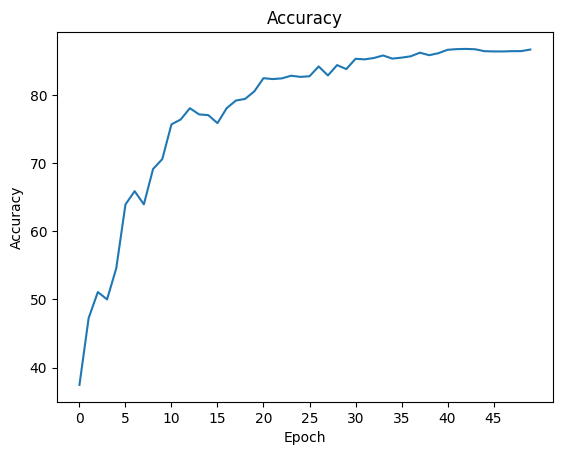

In [18]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()